In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import sklearn.linear_model as lm
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from google.colab import drive
import statsmodels.api as sm
from sklearn.metrics import r2_score

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Price_prediction.csv',na_values='?').dropna()
x=df
x

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0
6,1,158.0,audi,gas,std,four,sedan,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,17710.0
8,1,158.0,audi,gas,turbo,four,sedan,fwd,front,105.8,...,131,mpfi,3.13,3.40,8.3,140.0,5500.0,17,20,23875.0
10,2,192.0,bmw,gas,std,two,sedan,rwd,front,101.2,...,108,mpfi,3.50,2.80,8.8,101.0,5800.0,23,29,16430.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28,16845.0
201,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25,19045.0
202,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23,21485.0
203,-1,95.0,volvo,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106.0,4800.0,26,27,22470.0


In [ ]:
def col_rename(x:pd.DataFrame) -> list:
  col=x.columns
  coln=[]
  for i in range(len(col)):
    coln.append(col[i].replace('-','_'))
  return coln

In [ ]:
x.columns=col_rename(x)

In [ ]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 3 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          159 non-null    int64  
 1   normalized_losses  159 non-null    float64
 2   make               159 non-null    object 
 3   fuel_type          159 non-null    object 
 4   aspiration         159 non-null    object 
 5   num_of_doors       159 non-null    object 
 6   body_style         159 non-null    object 
 7   drive_wheels       159 non-null    object 
 8   engine_location    159 non-null    object 
 9   wheel_base         159 non-null    float64
 10  length             159 non-null    float64
 11  width              159 non-null    float64
 12  height             159 non-null    float64
 13  curb_weight        159 non-null    int64  
 14  engine_type        159 non-null    object 
 15  num_of_cylinders   159 non-null    object 
 16  engine_size        159 non

In [ ]:
x_quant = x.select_dtypes(exclude=[np.object])
x3=x_quant
x_quant.head(10)

<ipython-input-103-fe869f732131>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_quant = x.select_dtypes(exclude=[np.object])


,symboling,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
3,2,164.0,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0
6,1,158.0,105.8,192.7,71.4,55.7,2844,136,3.19,3.40,8.5,110.0,5500.0,19,25,17710.0
8,1,158.0,105.8,192.7,71.4,55.9,3086,131,3.13,3.40,8.3,140.0,5500.0,17,20,23875.0
10,2,192.0,101.2,176.8,64.8,54.3,2395,108,3.50,2.80,8.8,101.0,5800.0,23,29,16430.0
11,0,192.0,101.2,176.8,64.8,54.3,2395,108,3.50,2.80,8.8,101.0,5800.0,23,29,16925.0
12,0,188.0,101.2,176.8,64.8,54.3,2710,164,3.31,3.19,9.0,121.0,4250.0,21,28,20970.0
13,0,188.0,101.2,176.8,64.8,54.3,2765,164,3.31,3.19,9.0,121.0,4250.0,21,28,21105.0
18,2,121.0,88.4,141.1,60.3,53.2,1488,61,2.91,3.03,9.5,48.0,5100.0,47,53,5151.0
19,1,98.0,94.5,155.9,63.6,52.0,1874,90,3.03,3.11,9.6,70.0,5400.0,38,43,6295.0


<Axes: >

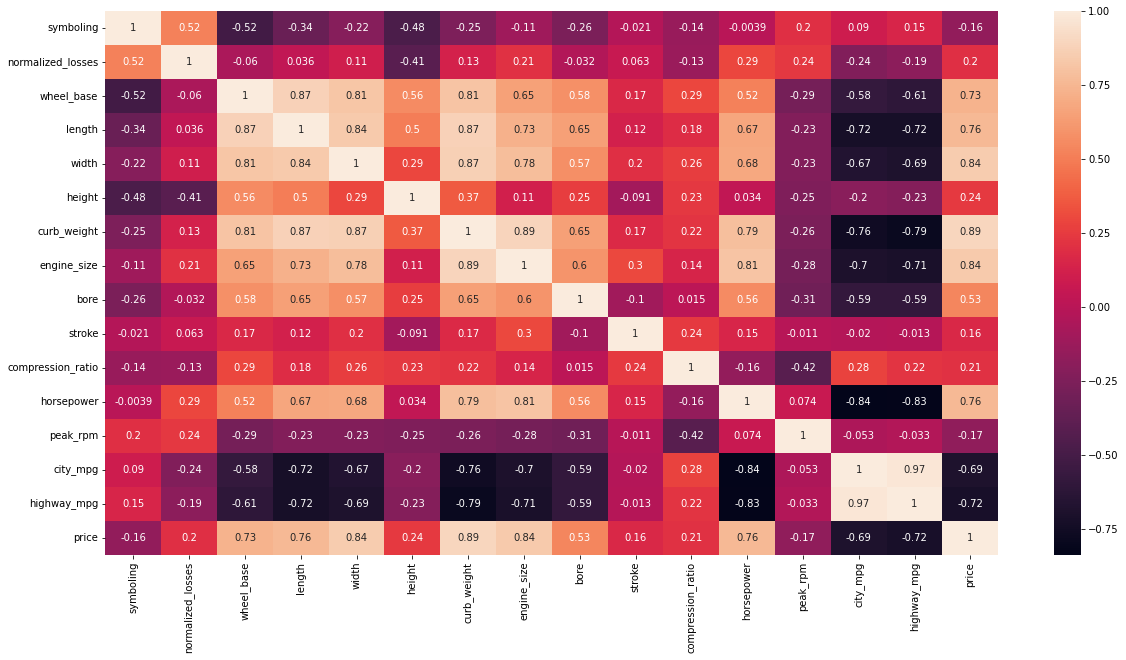

In [ ]:
plt.figure(figsize=[20,10])
sns.heatmap(x_quant.corr(),annot=True)

In [ ]:
# corr_matrix = x_quant.corr().abs()
# threshold = 0.8

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
# x_quant.drop(to_drop, axis=1, inplace=True)
# x_quant['price']=df['price']
# x_quant.head(5)

In [ ]:
def order(x:pd.DataFrame,target)-> list:
  col=list(x.columns)
  col_ord=[]
  for i in col:
    if i==target: continue
    max=[0,0]
    
    for j in range(1,10):
      fit=smf.ols(f'{target}~{i}+I({i}**{j})',x).fit()
      r2 = r2_score(x[target],fit.predict(x[i]))
      if r2>max[0]: max=[r2,j]
    col_ord.append([i,max[1]])
  return col_ord

In [ ]:
col_ord=order(x_quant,'price')

In [ ]:
col_ord

[['symboling', 3],
 ['normalized_losses', 2],
 ['wheel_base', 3],
 ['length', 5],
 ['width', 2],
 ['height', 2],
 ['curb_weight', 3],
 ['engine_size', 6],
 ['bore', 2],
 ['stroke', 9],
 ['compression_ratio', 2],
 ['horsepower', 6],
 ['peak_rpm', 2],
 ['city_mpg', 2],
 ['highway_mpg', 2]]

In [ ]:
def orderwise_fit(order:list,x_quant:pd.DataFrame,target:str)->None:
  for i in order:
    fit=smf.ols(f'{target}~I({i[0]}**{i[1]})',x_quant).fit()
    target_pred=fit.predict()
    print(i[0],i[1])
    print(fit.summary())
    print()
    print()


In [ ]:
orderwise_fit(order(x_quant,'price'),x,'price')

symboling 3
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     3.197
Date:                Mon, 20 Mar 2023   Prob (F-statistic):             0.0757
Time:                        07:34:36   Log-Likelihood:                -1603.5
No. Observations:                 159   AIC:                             3211.
Df Residuals:                     157   BIC:                             3217.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.105e+

In [ ]:
# def quant(x_quant:pd.DataFrame, col_ord:list, target:str)-> None: 
#   st=''
#   for i in col_ord:
#     st+=f'I({i[0]}**{i[1]})+'
#   fit=smf.ols(f'{target}~{st[0:len(st)-1]}',x_quant).fit()
#   print(fit.summary())
#   return st[0:len(st)-1]

In [ ]:
# st_quant=quant(x_quant,col_ord,'price')

In [ ]:
# test_fit=smf.ols(f'price~I(curb_weight**3)+I(width**2)',x).fit()
# test_fit.summary()

In [ ]:
xob = x.select_dtypes(include=[np.object])
xob.head(10)

<ipython-input-41-98c7d5cd6a52>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xob = x.select_dtypes(include=[np.object])


,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,engine_type,num_of_cylinders,fuel_system
3,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi
6,audi,gas,std,four,sedan,fwd,front,ohc,five,mpfi
8,audi,gas,turbo,four,sedan,fwd,front,ohc,five,mpfi
10,bmw,gas,std,two,sedan,rwd,front,ohc,four,mpfi
11,bmw,gas,std,four,sedan,rwd,front,ohc,four,mpfi
12,bmw,gas,std,two,sedan,rwd,front,ohc,six,mpfi
13,bmw,gas,std,four,sedan,rwd,front,ohc,six,mpfi
18,chevrolet,gas,std,two,hatchback,fwd,front,l,three,2bbl
19,chevrolet,gas,std,two,hatchback,fwd,front,ohc,four,2bbl


In [ ]:
def obj_wise(ob_list:list,x_ob:pd.DataFrame,target:str)->pd.DataFrame:
  """Will return encoded dataframe and dictionary with object-wise fit strings"""
  ob_st={}
  for i in ob_list:
    print(i)
    unique=list(x_ob[i].unique())
    if len(unique)==1: continue
    x_ob=pd.get_dummies(x_ob,columns=[i])
    x_ob.columns=col_rename(x_ob)
    st=''
    for j in range(len(unique)-1):
      st+=f'{i}_'+unique[j].replace('-','_')+'+'
    ob_st[i]=st[0:len(st)-1]
    fit=smf.ols(f'{target}~{ob_st[i]}',x_ob).fit()
    print(fit.summary())
    print()
    print()
  return x_ob,ob_st

In [ ]:
x2,st=obj_wise(list(xob.columns),x,'price')

make
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     28.52
Date:                Mon, 20 Mar 2023   Prob (F-statistic):           2.83e-37
Time:                        06:08:41   Log-Likelihood:                -1486.6
No. Observations:                 159   AIC:                             3009.
Df Residuals:                     141   BIC:                             3064.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.806e+04  

In [ ]:
st

{'make': 'make_audi+make_bmw+make_chevrolet+make_dodge+make_honda+make_jaguar+make_mazda+make_mercedes_benz+make_mitsubishi+make_nissan+make_peugot+make_plymouth+make_porsche+make_saab+make_subaru+make_toyota+make_volkswagen',
 'fuel_type': 'fuel_type_gas',
 'aspiration': 'aspiration_std',
 'num_of_doors': 'num_of_doors_four',
 'body_style': 'body_style_sedan+body_style_hatchback+body_style_wagon+body_style_hardtop',
 'drive_wheels': 'drive_wheels_fwd+drive_wheels_4wd',
 'engine_type': 'engine_type_ohc+engine_type_l+engine_type_dohc+engine_type_ohcv',
 'num_of_cylinders': 'num_of_cylinders_four+num_of_cylinders_five+num_of_cylinders_six+num_of_cylinders_three',
 'fuel_system': 'fuel_system_mpfi+fuel_system_2bbl+fuel_system_mfi+fuel_system_1bbl+fuel_system_idi'}

In [ ]:
st['make']+='-make_audi-make_bmw-make_peugot-make_porsche-make_saab'
st['fuel_system']+='-fuel_system_2bbl-fuel_system_mfi-fuel_system_1bbl'

In [ ]:
fit_make=smf.ols(f'price~I(curb_weight**3)+{st["make"]}+{st["num_of_cylinders"]}',x2).fit()
fit_make.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     80.62
Date:                Mon, 20 Mar 2023   Prob (F-statistic):           9.13e-64
Time:                        06:08:41   Log-Likelihood:                -1416.5
No. Observations:                 159   AIC:                             2869.
Df Residuals:                     141   BIC:                             2924.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1.931e+04   2534.819      7.619      0.000    1.43e+04    2.43e+04
I(curb_weight ** 3)     2.612e-07   3.13e-08      8.356      0.000    1.99e-07    3.23e-07
make_chevrolet         -5338.1244   1484.516     -3.596      0.000   -8272.910   -2403.339
make_dodge             -4980.0643    859.887     -5.792      0.000   -6680.002   -3280.127
make_honda             -4316.2864    769.866     -5.607      0.000   -5838.258   -2794.314
make_jaguar             1029.5162   2222.328      0.463      0.644   -3363.873    5422.906
make_mazda             -3862.7798    774.676     -4.986      0.000   -5394.262   -2331.298
make_mercedes_benz      2672.1192   1621.674      1.648      0.102    -533.819    5878.058
make_mitsubishi        -5147.2053    794.588     -6.478      0.000   -6718.052   -3576.359
make_nissan            -4976.5021    685.354     -7.261      0.000   -6331.400   -3621.604
make_plymouth          -5409.2748    953.643     -5.672      0.000   -7294.561   -3523.988
make_subaru            -4762.1797    736.031     -6.470      0.000   -6217.263   -3307.096
make_toyota            -4569.9152    573.990     -7.962      0.000   -5704.654   -3435.176
make_volkswagen        -4275.0622    846.695     -5.049      0.000   -5948.921   -2601.204
num_of_cylinders_four  -9308.7395   2420.040     -3.847      0.000   -1.41e+04   -4524.487
num_of_cylinders_five  -6157.8510   2125.551     -2.897      0.004   -1.04e+04   -1955.781
num_of_cylinders_six   -5651.0256   2487.885     -2.271      0.025   -1.06e+04    -732.648
num_of_cylinders_three -9685.2297   3362.905     -2.880      0.005   -1.63e+04   -3036.997
==============================================================================
Omnibus:                       21.883   Durbin-Watson:                   1.376
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.519
Skew:                           0.477   Prob(JB):                     2.66e-14
Kurtosis:                       5.920   Cond. No.                     7.08e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.08e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
st['make']+='-make_jaguar-make_mercedes_benz'

In [ ]:
fit_make=smf.ols(f'price~I(curb_weight**3)+{st["make"]}+{st["num_of_cylinders"]}',x2).fit()
fit_make.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     90.74
Date:                Mon, 20 Mar 2023   Prob (F-statistic):           3.83e-66
Time:                        07:39:33   Log-Likelihood:                -1412.8
No. Observations:                 159   AIC:                             2860.
Df Residuals:                     142   BIC:                             2912.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               2.097e+04   2234.716      9.382      0.000    1.65e+04    2.54e+04
I(curb_weight ** 3)     2.565e-07   2.67e-08      9.592      0.000    2.04e-07    3.09e-07
I(horsepower ** 6)       9.06e-11   2.93e-11      3.092      0.002    3.27e-11    1.49e-10
make_chevrolet         -5137.0043   1421.993     -3.613      0.000   -7948.017   -2325.992
make_dodge             -4879.0370    815.241     -5.985      0.000   -6490.614   -3267.460
make_honda             -4124.2346    717.998     -5.744      0.000   -5543.581   -2704.888
make_mazda             -3672.8833    730.450     -5.028      0.000   -5116.845   -2228.922
make_mitsubishi        -5005.5931    751.583     -6.660      0.000   -6491.331   -3519.855
make_nissan            -5057.2498    656.752     -7.700      0.000   -6355.524   -3758.976
make_plymouth          -5212.9603    904.247     -5.765      0.000   -7000.485   -3425.435
make_subaru            -4575.8353    697.243     -6.563      0.000   -5954.152   -3197.518
make_toyota            -4425.6360    540.999     -8.180      0.000   -5495.088   -3356.184
make_volkswagen        -4072.4793    803.537     -5.068      0.000   -5660.920   -2484.038
num_of_cylinders_four  -1.114e+04   1992.255     -5.592      0.000   -1.51e+04   -7203.298
num_of_cylinders_five  -6432.4971   2009.265     -3.201      0.002   -1.04e+04   -2460.561
num_of_cylinders_six   -8547.4770   1966.315     -4.347      0.000   -1.24e+04   -4660.443
num_of_cylinders_three -1.153e+04   3037.183     -3.795      0.000   -1.75e+04   -5521.100
==============================================================================
Omnibus:                       21.443   Durbin-Watson:                   1.293
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.217
Skew:                           0.492   Prob(JB):                     3.76e-13
Kurtosis:                       5.769   Cond. No.                     2.35e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.35e+14. This might indicate that there are
strong multicollinearity or other numerical problems.
"""